# Protein–DNA ΔΔG: Support Vector Regression (SVR) — Walkthrough

A crisp, end-to-end **exercise** notebook that fits an SVM regressor to predict ΔΔG from engineered features.

**Flow**
1) Load & merge `rawdat.csv` + `exp_data_all.csv`  
2) Quick data audit  
3) Define features/target **with leakage guard**  
4) Train/test split  
5) Baseline (mean) predictor  
6) **SVR (RBF)** pipeline (scaling inside the pipeline)  
7) Evaluate + plots (true vs pred, residuals)  
8) Model-agnostic **permutation importance**  
9) PDPs (top 3 features)  
10) *(Optional)* mini parameter sweep (very small grid)  


## 0. Setup & Configuration
Adjust the paths if your repo layout differs.


In [1]:
# --- stdlib ---
import os, math, json
from pathlib import Path

# --- scientific stack ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- sklearn ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------- Project paths (Path objects only) --------
PROJECT_ROOT = Path.cwd()          # or Path('.'), but keep as Path
INPUTS_DIR   = PROJECT_ROOT
OUTPUT_DIR   = PROJECT_ROOT / "ML_NN_CV"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# -------- Column identifiers --------
SEQUENCE_ID = "sequence"    # Unique key across files
LABEL_COL   = "bind_avg"    # ΔΔG label

# -------- Input files (Path objects) --------
FEATURE_FILES  = [INPUTS_DIR / "rawdat.csv"]        # list in case you add more later
REFERENCE_FILE = INPUTS_DIR / "exp_data_all.csv"

print(f"Inputs dir: {INPUTS_DIR}")
print(f"Outputs dir: {OUTPUT_DIR}")
print(f"Feature file(s): {FEATURE_FILES}")
print(f"Reference file: {REFERENCE_FILE}")


Inputs dir: /Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks
Outputs dir: /Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks/ML_NN_CV
Feature file(s): [PosixPath('/Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks/rawdat.csv')]
Reference file: /Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks/exp_data_all.csv


## 1. Load & Merge

- Load engineered features (`rawdat.csv`)  
- Load experimental labels (`exp_data_all.csv`)  
- Merge on `SEQUENCE_ID` and drop rows with missing label


In [2]:
# load features
features = pd.read_csv(FEATURE_FILES[0])

# optional: normalize sequence IDs (example: strip prefix)
if SEQUENCE_ID in features.columns:
    features[SEQUENCE_ID] = features[SEQUENCE_ID].astype(str).str.replace("MycMax_", "", regex=False)

# load labels
labels = pd.read_csv(REFERENCE_FILE)

# merge
df = features.merge(labels, on=SEQUENCE_ID, how="inner").dropna(subset=[LABEL_COL]).reset_index(drop=True)

print("Merged shape:", df.shape)
display(df.head(3))


Merged shape: (68040, 13)


,sequence,run,VDWAALS,EEL,EGB,ESURF,HB Energy,Hydrophobic Energy,Pi-Pi Energy,Delta_Entropy,bind_avg,binding_type,improving
0,CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA,9,-236.997,-1869.660,1823.216,-35.292,-2.590101,-156.445725,-4.282747,-24.750849,0.166339,1,0
1,CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA,9,-218.620,-1850.331,1807.831,-32.521,-2.977171,-142.709472,-7.240534,-25.235404,0.166339,1,0
2,CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA,9,-232.611,-1878.075,1834.181,-34.170,-3.105868,-145.088977,-8.856276,-25.124940,0.166339,1,0


## 2. Quick Data Audit

Look for dtypes, missingness, duplicates, and a quick numeric summary.


In [3]:
print("\nDataFrame info:")
df.info()

print("\nMissing values per column (top 20):")
display(df.isna().sum().sort_values(ascending=False).head(20))

dup = df.duplicated(subset=[SEQUENCE_ID]).sum()
print(f"\nDuplicate {SEQUENCE_ID} rows:", dup)

print("\nDescriptive stats (numeric):")
display(df.describe().T.head(15))



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68040 entries, 0 to 68039
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sequence            68040 non-null  object 
 1   run                 68040 non-null  int64  
 2   VDWAALS             68040 non-null  float64
 3   EEL                 68040 non-null  float64
 4   EGB                 68040 non-null  float64
 5   ESURF               68040 non-null  float64
 6   HB Energy           68040 non-null  float64
 7   Hydrophobic Energy  68040 non-null  float64
 8   Pi-Pi Energy        68040 non-null  float64
 9   Delta_Entropy       68040 non-null  float64
 10  bind_avg            68040 non-null  float64
 11  binding_type        68040 non-null  int64  
 12  improving           68040 non-null  int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 6.7+ MB

Missing values per column (top 20):


sequence              0
run                   0
VDWAALS               0
EEL                   0
EGB                   0
ESURF                 0
HB Energy             0
Hydrophobic Energy    0
Pi-Pi Energy          0
Delta_Entropy         0
bind_avg              0
binding_type          0
improving             0
dtype: int64


Duplicate sequence rows: 67998

Descriptive stats (numeric):


,count,mean,std,min,25%,50%,75%,max
run,68040.0,10.500000,5.766324,1.000000,5.750000,10.500000,15.250000,20.000000
VDWAALS,68040.0,-201.378166,20.130228,-270.351000,-215.101000,-201.824000,-188.088000,-105.281000
EEL,68040.0,-1898.996636,38.450855,-2076.822000,-1924.672000,-1897.880000,-1873.026000,-1758.701000
EGB,68040.0,1850.679788,35.684319,1722.168000,1826.616000,1849.566000,1874.488000,2013.174000
ESURF,68040.0,-31.474066,2.393914,-43.027000,-33.082000,-31.535000,-29.954000,-18.292000
HB Energy,68040.0,-8.175591,6.065805,-30.470945,-13.585766,-4.378422,-3.275576,-0.324696
Hydrophobic Energy,68040.0,-135.669642,13.021100,-181.225207,-144.756364,-136.267018,-127.247098,-65.594027
Pi-Pi Energy,68040.0,-3.219995,2.584144,-17.248618,-4.999256,-2.974733,-0.964479,0.000000
Delta_Entropy,68040.0,-21.768632,2.156622,-33.004332,-23.182778,-21.798697,-20.392486,-9.803474
bind_avg,68040.0,0.182705,0.834584,-0.862667,-0.511587,-0.027842,0.614097,2.035660


## 3. Define Features & Target (with Leakage Guard)

We keep **numeric** features and explicitly exclude potential label leakage columns:
- `binding_type`, `improving` (label-like helpers)  
- the true label `bind_avg`  
- the identifier `sequence`


In [4]:
LEAKAGE_COLS = {SEQUENCE_ID, LABEL_COL, "binding_type", "improving"}

# numeric-only features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# remove known non-features
feature_cols = [c for c in numeric_cols if c not in LEAKAGE_COLS]

X = df[feature_cols].copy()
y = df[LABEL_COL].copy()

print("Excluded columns present:", sorted(list(set(LEAKAGE_COLS) & set(df.columns))))
print("Feature count:", len(feature_cols))
print("X shape:", X.shape, "| y shape:", y.shape)

# drop constants
const_cols = [c for c in feature_cols if X[c].nunique(dropna=False) <= 1]
if const_cols:
    print("Dropping constant features:", const_cols)
    X = X.drop(columns=const_cols)
    feature_cols = [c for c in feature_cols if c not in const_cols]

print("Final feature count:", len(feature_cols))


Excluded columns present: ['bind_avg', 'binding_type', 'improving', 'sequence']
Feature count: 9
X shape: (68040, 9) | y shape: (68040,)
Final feature count: 9


## 4. Train/Test Split (80/20)

Keep a hold-out test set for honest final evaluation.


In [5]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df[SEQUENCE_ID], test_size=0.2, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (54432, 9)  Test: (13608, 9)


## 5. Baseline (Mean Predictor)

A simple floorline: always predict the training mean of ΔΔG.


In [6]:
y_mean = np.full_like(y_test, y_train.mean(), dtype=float)
base_r2   = r2_score(y_test, y_mean)
base_rmse = math.sqrt(mean_squared_error(y_test, y_mean))
base_mae  = mean_absolute_error(y_test, y_mean)

print(f"Baseline — R²: {base_r2:.4f} | RMSE: {base_rmse:.4f} | MAE: {base_mae:.4f}")


Baseline — R²: -0.0000 | RMSE: 0.8333 | MAE: 0.6773


## 6. SVR Pipeline (RBF kernel)

We scale inputs **inside** the pipeline (prevents leakage and keeps code clean).

**Starter hyperparams** (reasonable defaults for an exercise):
- kernel = 'rbf'  
- C = 10.0  
- gamma = 'scale' (i.e., 1/(n_features * X.var))  
- epsilon = 0.1  


In [7]:
svr = SVR(kernel="rbf", C=10.0, gamma="scale", epsilon=0.1)

svr_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svr", svr)
])

svr_pipe.fit(X_train, y_train)
y_pred = svr_pipe.predict(X_test)

test_r2   = r2_score(y_test, y_pred)
test_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
test_mae  = mean_absolute_error(y_test, y_pred)

print(f"SVR (RBF) — Test R²: {test_r2:.4f} | RMSE: {test_rmse:.4f} | MAE: {test_mae:.4f}")


SVR (RBF) — Test R²: 0.1895 | RMSE: 0.7502 | MAE: 0.5585


## 7. Diagnostics: True vs Predicted, and Residuals

Quick visual checks for fit quality and systematic bias.


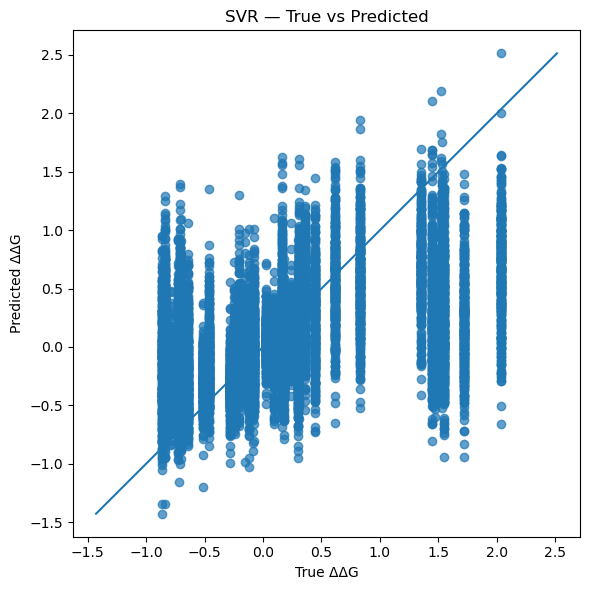

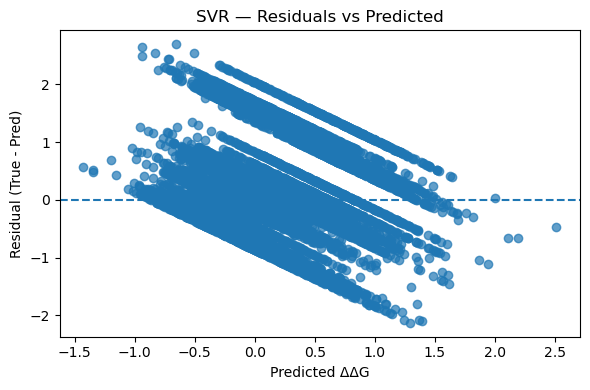

In [8]:
# 1) True vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
lo, hi = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([lo, hi], [lo, hi])
plt.xlabel("True ΔΔG")
plt.ylabel("Predicted ΔΔG")
plt.title("SVR — True vs Predicted")
plt.tight_layout()
plt.show()

# 2) Residuals vs Predicted
resid = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, resid, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted ΔΔG")
plt.ylabel("Residual (True - Pred)")
plt.title("SVR — Residuals vs Predicted")
plt.tight_layout()
plt.show()


## 8. Permutation Importance (model-agnostic)

Since SVR doesn't expose native feature importance, we use **permutation importance** on the test set.
We report the top 20 features by drop in R² when permuted.


,feature,importance_mean,importance_std
2,EEL,6.106505,0.042505
3,EGB,5.954612,0.076146
6,Hydrophobic Energy,0.488048,0.010556
4,ESURF,0.414409,0.008801
8,Delta_Entropy,0.201561,0.006021
1,VDWAALS,0.137592,0.005243
5,HB Energy,0.107176,0.004118
7,Pi-Pi Energy,0.047799,0.002529
0,run,0.046505,0.002464


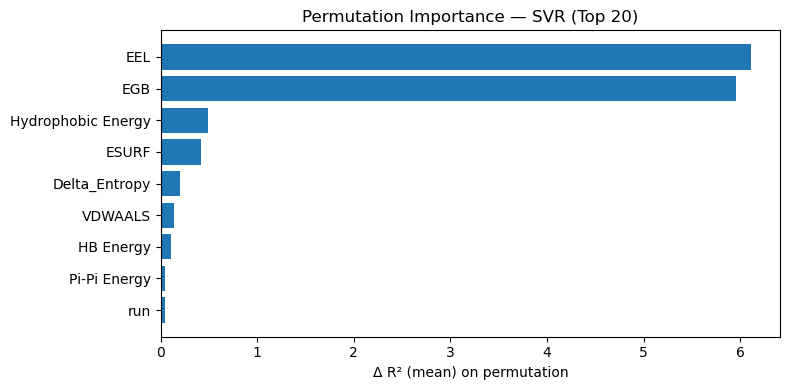

In [9]:
perm = permutation_importance(
    svr_pipe, X_test, y_test,
    scoring="r2", n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)

perm_imp = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

display(perm_imp.head(20))

topk = 20 if len(perm_imp) > 20 else len(perm_imp)
top_perm = perm_imp.head(topk)

plt.figure(figsize=(8, max(4, topk*0.3)))
plt.barh(top_perm["feature"][::-1], top_perm["importance_mean"][::-1])
plt.xlabel("Δ R² (mean) on permutation")
plt.title("Permutation Importance — SVR (Top 20)")
plt.tight_layout()
plt.show()


## 9. Partial Dependence (PDP)

Visualize marginal effects for the **top 3** important features (from permutation importance).


In [10]:
top3 = perm_imp["feature"].head(3).tolist()
print("Top 3 features for PDP:", top3)

for feat in top3:
    plt.figure(figsize=(6,4))
    try:
        PartialDependenceDisplay.from_estimator(svr_pipe, X_train, [feat])
        plt.suptitle(f"PDP — {feat}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Skipping PDP for {feat}: {e}")


Top 3 features for PDP: ['EEL', 'EGB', 'Hydrophobic Energy']


KeyboardInterrupt: 

<Figure size 600x400 with 0 Axes>

## 10. *(Optional)* Mini Parameter Sweep (tiny grid)

A **very small** grid over `C` and `gamma` to illustrate sensitivity.  
Uses 3-fold CV on the **training set only**, then we refit the best and evaluate once.


In [ ]:
from itertools import product
from sklearn.model_selection import KFold

Cs     = [1.0, 10.0, 100.0]
gammas = ["scale", 0.01, 0.001]

kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

results = []
for C_val, g_val in product(Cs, gammas):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svr", SVR(kernel="rbf", C=C_val, gamma=g_val, epsilon=0.1))
    ])
    cv_r2 = cross_val_score(pipe, X_train, y_train, cv=kf, scoring="r2", n_jobs=-1)
    results.append({"C": C_val, "gamma": g_val, "cv_r2_mean": float(cv_r2.mean())})

sweep_df = pd.DataFrame(results).sort_values("cv_r2_mean", ascending=False)
display(sweep_df)
best = sweep_df.iloc[0].to_dict()
print("Best (tiny grid):", best)

# Refit best on full train and evaluate once on test
best_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="rbf", C=best["C"], gamma=best["gamma"], epsilon=0.1))
])
best_pipe.fit(X_train, y_train)
y_pred_best = best_pipe.predict(X_test)

print("Best tiny-grid SVR — Test R²:", r2_score(y_test, y_pred_best))
print("Best tiny-grid SVR — Test RMSE:", math.sqrt(mean_squared_error(y_test, y_pred_best)))
print("Best tiny-grid SVR — Test MAE:", mean_absolute_error(y_test, y_pred_best))


## Notes & Next Steps

- Use **GroupKFold** if sequences cluster by protein/backbone to avoid leakage.  
- Try `epsilon` tuning: larger epsilon can be more robust to noise.  
- Consider alternative kernels (poly, sigmoid) — RBF is the usual strong default.  
- For thorough work, expand the grid (C, gamma, epsilon) and include nested CV.  
- Compare against RF/NN baselines you already built.
